# Исследование поведения покупателей (анализ покупок) с  применением когортного и RFM-анализа

**Необходимо ответить на следующие вопросы:**
* Сколько у нас пользователей, которые совершили покупку только один раз? 
* Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
* По каждому товару определить, в какой день недели товар чаще всего покупается. 
* Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? (Внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть) 
* Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 
* Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. Выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. 

### Описание таблиц

**olist_customers_dataset.csv** — таблица с уникальными идентификаторами пользователей
* **customer_id** — позаказный идентификатор пользователя (аналог номера паспорта)
* **customer_unique_id** —  уникальный идентификатор пользователя
* **customer_zip_code_prefix** —  почтовый индекс пользователя
* **customer_city** —  город доставки пользователя
* **customer_state** —  регион доставки пользователя

**olist_orders_dataset.csv** —  таблица заказов
* **order_id** —  уникальный идентификатор заказа (номер чека)
* **customer_id** —  позаказный идентификатор пользователя (аналог номера паспорта)
* **order_status** —  статус заказа
* **order_purchase_timestamp** —  время создания заказа
* **order_approved_at** —  время подтверждения оплаты заказа
* **order_delivered_carrier_date** —  время передачи заказа в логистическую службу
* **order_delivered_customer_date** —  время доставки заказа
* **order_estimated_delivery_date** —  обещанная дата доставки

**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы
* **order_id** —  уникальный идентификатор заказа (номер чека)
* **order_item_id** —  идентификатор товара внутри одного заказа
* **product_id** —  ид товара (аналог штрихкода)
* **seller_id** — ид производителя товара
* **shipping_limit_date** —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
* **price** —  цена за единицу товара
* **freight_value** —  вес товара

#### Статусы заказа - order_status (olist_orders_dataset.csv):
* created —  создан
* approved —  подтверждён
* invoiced —  выставлен счёт
* processing —  в процессе сборки заказа
* shipped —  отгружен со склада
* delivered —  доставлен пользователю
* unavailable —  недоступен
* canceled —  отменён


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
# Считываем все три таблицы, проверяем размерность и типы данных

In [3]:
# 1 таблица с уникальными идентификаторами пользователей
df_customers = pd.read_csv("csv/olist_customers_dataset.csv")
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
df_customers.shape

(99441, 5)

In [5]:
df_customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
# 2 таблица заказов
df_orders = pd.read_csv("csv/olist_orders_dataset.csv", 
                        parse_dates=['order_purchase_timestamp','order_delivered_carrier_date',
                                     'order_delivered_customer_date', 'order_estimated_delivery_date'])
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
df_orders.shape

(99441, 8)

In [8]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [9]:
# 3 таблица - товарные позиции, входящие в заказы
df_items = pd.read_csv("csv/olist_order_items_dataset.csv", parse_dates= ['shipping_limit_date'])
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [10]:
df_items.shape

(112650, 7)

In [11]:
df_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object


### 1. Сколько пользователей совершили покупку только один раз

In [12]:
# Необходимо:
# - Связать таблицы ПОЛЬЗОВАТЕЛЕЙ и ЗАКАЗОВ
# - Оставить только те строки, где произошла покупка.
# Покупка это:
#     В таблице ЗАКАЗОВ: время подтверждения оплаты заказа (order_approved_at) - не пусто AND
#     Статус заказа (order_status): (NO canceled)  AND (NO unavailable)
           

In [13]:
# Связываем таблицы ПОЛЬЗОВАТЕЛЕЙ и ЗАКАЗОВ
df_orders_customers = df_orders.merge(df_customers)

In [14]:
df_orders_customers.shape

(99441, 12)

In [15]:
# На всякий случай посмотрим: сколько пустых строк с "order_approved_at" - подтверждением оплаты, такие строки есть ?

In [16]:
order_approved_at_isna = df_orders_customers.order_approved_at.isna()

In [17]:
df_orders_customers[order_approved_at_isna].shape[0]

160

In [18]:
# Фильтрация: оставим только РЕАЛЬНЫЕ покупки

In [19]:
df_orders_customers_yes = df_orders_customers \
    .query("order_status != 'unavailable' and order_status != 'canceled'")[df_orders_customers.order_approved_at.notna()]

C:\Users\OSTAP\AppData\Local\Temp/ipykernel_6632/1134831115.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_orders_customers_yes = df_orders_customers \


In [20]:
df_orders_customers_yes.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [21]:
df_orders_customers_yes.shape

(98188, 12)

In [22]:
# Группируем по УНИКАЛЬНЫМ ID пользователей
df_orders_customers_yes.groupby("customer_unique_id") \
                .agg({"order_id" : "count"}) \
                .rename({"order_id" : "order_count"}, axis='columns') \
                .query("order_count == 1").shape[0]

92087

> **Решение: всего - 92087 пользователей, которые совершили покупку только один раз**

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

In [23]:
# Работаем с таблицей заказов - df_orders
# В качестве базовой даты используем - order_estimated_delivery_date (обещанная дата доставки)

In [24]:
# Создаем новое поле ГОД-МЕСЯЦ-обещанной даты доставки
df_orders['order_estimated_delivery_date_YM'] =  df_orders.order_estimated_delivery_date.apply(lambda x: str(x)[:7])
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_date_YM
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02


In [25]:
# Необходимо получить только НЕ доставленные заказы. 
# Т.е. выбираем ТОЛЬКО строки со статусами: canceled(отказ) и unavailable(невозможность доставить) 
# Сделаем новую таблицу с отфильтрофанными значениями
df_orders_bad = df_orders.query("order_status == 'canceled' or order_status == 'unavailable'")
df_orders_bad.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_date_YM
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-12
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2018-02
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-02
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,2017-09


In [26]:
# Сделаем перекрестную таблицу
df_orders_bad_pivot_table = df_orders_bad.pivot_table(index='order_estimated_delivery_date_YM', columns='order_status', values= 'customer_id', aggfunc='count', fill_value=0)
df_orders_bad_pivot_table.head()

order_status,canceled,unavailable
order_estimated_delivery_date_YM,,
2016-09,1,0
2016-10,3,0
2016-11,14,5
2016-12,8,2
2017-02,2,2


In [27]:
# Обращаем внимание, что в некоторых месяцах отказов по причине "unavailable" не было (0), 
# но эти месяцы все равно должны учасвствовать в расчете среднего 

In [28]:
# Среднее кол-во недоставленных заказов по причине отмены (canceled)
mean_canceled = round(df_orders_bad_pivot_table.canceled.mean(), 1)
mean_canceled

24.0

In [29]:
# Среднее кол-во недоставленных заказов по причине недоступности (unavailable)
mean_unavailable = round(df_orders_bad_pivot_table.unavailable.mean(), 1)
mean_unavailable

23.4

In [30]:
# Среднее кол-во недоставленных заказов - по всем причинам


In [31]:
round((mean_canceled + mean_unavailable), 1)

47.4

> **Решение: В среднем не доставляется 47.4 заказов в месяц. Из них, по причине "отмены" - 24.0, по причине "недоступности" - 47.4** 

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается

In [32]:
# Посмотрим, сколько всего УНИКАЛЬНЫХ товаров
df_items.product_id.nunique()

32951

In [33]:
# Связываем таблицы  ЗАКАЗОВ и ТОВАРОВ 
df_orders_items = df_orders.merge(df_items)
df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_date_YM,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [34]:
# Фильтрация: оставим только РЕАЛЬНЫЕ покупки (как во второй задаче)

In [35]:
df_orders_items_yes = df_orders_items \
    .query("order_status != 'unavailable' and order_status != 'canceled'")[df_orders_items.order_approved_at.notna()]
df_orders_items_yes.head()

C:\Users\OSTAP\AppData\Local\Temp/ipykernel_6632/2469047512.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_orders_items_yes = df_orders_items \


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_date_YM,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [36]:
# order_purchase_timestamp - время создания заказа. Будем считать это датой покупки
# Создадим новое поле - день недели создания заказа
df_orders_items_yes['order_purchase_week'] = df_orders_items_yes.order_purchase_timestamp.dt.day_name()
df_orders_items_yes.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_date_YM,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [37]:
# Группируем по: товару-дню недели 
# Считаем - кол-во товаров
df_items_sales_per_week = df_orders_items_yes.groupby(['product_id', 'order_purchase_week'], as_index=False) \
                    .agg({'customer_id':'count'}) \
                    .rename(columns={'customer_id':'count_product'})
df_items_sales_per_week

,product_id,order_purchase_week,count_product
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60876,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60877,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
60878,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60879,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [38]:
# Видим, что в некоторых днях недели продаются одинаковое кол-во товара. Это необходимо учитывать

In [39]:
# Таблица, в которой по результатам группировки остаются товары с максимальным значением продаж в разные дни недели
# Таких дней для каждого товара м.б. несколько!
idx = df_items_sales_per_week.groupby(['product_id'])['count_product'].transform(max) == df_items_sales_per_week['count_product']
df_items_max_sales_per_week = df_items_sales_per_week[idx]
df_items_max_sales_per_week

,product_id,order_purchase_week,count_product
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60873,fff6177642830a9a94a0f2cba5e476d1,Sunday,1
60874,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
60875,fff9553ac224cec9d15d49f5a263411f,Friday,1
60879,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [40]:
# Создаем СПИСОК - перечисление дней недели, когда были максимальные продажи для товара
df_items_list_week = df_items_max_sales_per_week.groupby('product_id')['order_purchase_week'] \
                    .apply(list) \
                    .reset_index() \
                    .rename({'order_purchase_week':'list_week'}, axis='columns')
df_items_list_week.head()

,product_id,list_week
0,00066f42aeeb9f3007548bb9d3f33c38,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,[Thursday]
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,[Tuesday]


In [41]:
# Создадим отдельный DF ТОВАР-МасимальноеЧислоПродажВденьНедели 

In [42]:
df_items_max_sales_in_day_of_week = df_items_max_sales_per_week.drop_duplicates('product_id') \
                            .rename({'count_product':'max_in_day_week'}, axis='columns')[['product_id','max_in_day_week']]
df_items_max_sales_in_day_of_week

,product_id,max_in_day_week
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
5,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
60872,fff6177642830a9a94a0f2cba5e476d1,1
60874,fff81cc3158d2725c0655ab9ba0f712c,1
60875,fff9553ac224cec9d15d49f5a263411f,1
60879,fffdb2d0ec8d6a61f0a0a0db3f25b441,2


In [43]:
# И еще DF: ПРОДУКТ - всего продаж
df_items_total_sales = df_items_sales_per_week \
                        .groupby('product_id', as_index=False) \
                        .agg({'count_product':'sum'}) \
                        .rename({'count_product':'total_sales'}, axis='columns')
df_items_total_sales    

,product_id,total_sales
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32721,fff6177642830a9a94a0f2cba5e476d1,2
32722,fff81cc3158d2725c0655ab9ba0f712c,1
32723,fff9553ac224cec9d15d49f5a263411f,1
32724,fffdb2d0ec8d6a61f0a0a0db3f25b441,5


In [44]:
# Объединяем ТРИ таблицы
df_result = df_items_list_week.merge(df_items_max_sales_in_day_of_week) \
                            .merge(df_items_total_sales) \
                            .sort_values('total_sales', ascending=False)
df_result

,product_id,list_week,max_in_day_week,total_sales
21957,aca2eb7d00ea1a7b8ebd4e68314663af,[Thursday],89,527
19597,99a4788cb24856965c36a24e339b6058,[Monday],92,487
8553,422879e10f46682990de24d770e7f83d,[Wednesday],93,484
7313,389d119b48cf3043d311335e499d9c6b,[Thursday],67,391
7032,368c6c730842d78016ad823897a372db,[Friday],67,388
...,...,...,...,...
13958,6cd1945e89970ad5992f82541a227c36,[Thursday],1,1
13953,6cc77f7f5a82f5afe9ededad3e9d9400,[Saturday],1,1
13951,6cc58e27cae22a37b784841f0e4fb647,[Thursday],1,1
13949,6cc2b92f841b20c5e39281a44a9c68bc,[Friday],1,1


In [45]:
# Сохраняем результат в CSV-файл
df_result.to_csv("result_3.csv", index=False)

In [46]:
# Подсчитаем самый популярый день недели среди ВСЕХ товаров
df_orders_items_yes.groupby('order_purchase_week') \
                .agg({'product_id':'count'}).idxmax()

product_id    Monday
dtype: object

> **Решение: составлена таблица с 32726 строками (файл "result_3.csv"). В ней рассчитано по каждому товару:**
>* Список дней недели, с самыми большими продажами
>* Кол-во продаж в эти дни
>* Общая сумма продаж по продукту
>Таблица отсортирована по общей сумме продаж в поряке убывания. 
> Самый популярый день недели среди ВСЕХ товаров - **Понедельник**

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

##### Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [47]:
# Работаем с уже готовой таблицей "df_orders_customers_yes" - сделана из двух таблиц и отфильтрована (удалены НЕудавшиеся покупки)
# order_purchase_timestamp - время создания заказа. Будем считать это датой покупки
df_orders_customers_yes

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [48]:
# Создаем новое поле ГОД-МЕСЯЦ покупки (order_purchase_YM)
df_orders_customers_yes['order_purchase_YM'] =  df_orders_customers_yes \
        .order_purchase_timestamp \
        .apply(lambda x: str(x)[:7] + '-01') \
        .apply(pd.to_datetime)
df_orders_customers_yes.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02-01


In [49]:
# Для каждого пользователя считаем ко-во покупок в каждом месяце. Группироем по ПОЛЬЗОВАТЕЛЬ-МЕСЯЦ
df_purchases_monthly = df_orders_customers_yes \
                        .groupby(['customer_unique_id','order_purchase_YM'], as_index=False) \
                        .agg({'order_id':'count'}) \
                        .rename(columns={'order_id':'count_purchase'})
df_purchases_monthly

,customer_unique_id,order_purchase_YM,count_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1
...,...,...,...
96845,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1
96846,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1
96847,ffff371b4d645b6ecea244b27531430a,2017-02-01,1
96848,ffff5962728ec6157033ef9805bacc48,2018-05-01,1


In [50]:
# Добавим в таблицу "df_purchases_monthly" поле "days_in_month" - кол-во дней в месяце
df_purchases_monthly['days_in_month'] = df_purchases_monthly.order_purchase_YM.dt.days_in_month
df_purchases_monthly

,customer_unique_id,order_purchase_YM,count_purchase,days_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,31
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,31
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,31
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,30
...,...,...,...,...
96845,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,30
96846,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,31
96847,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,28
96848,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,31


In [51]:
# Добавим в таблицу "df_purchases_monthly" поле "average_per_week" - среднее кол-во покупок в неделю
df_purchases_monthly['average_per_week'] = df_purchases_monthly.count_purchase / (df_purchases_monthly.days_in_month / 7)
df_purchases_monthly

,customer_unique_id,order_purchase_YM,count_purchase,days_in_month,average_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,31,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,31,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,31,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,30,0.233333
...,...,...,...,...,...
96845,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,30,0.233333
96846,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,31,0.225806
96847,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,28,0.250000
96848,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,31,0.225806


In [52]:
# Отсортируем таблицу customer_unique_id-order_purchase_YM
df_purchases_monthly.sort_values(['customer_unique_id', 'order_purchase_YM'])

,customer_unique_id,order_purchase_YM,count_purchase,days_in_month,average_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,31,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,31,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,31,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,30,0.233333
...,...,...,...,...,...
96845,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,30,0.233333
96846,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,31,0.225806
96847,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,28,0.250000
96848,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,31,0.225806


In [53]:
# Число уникальных пользователей
df_purchases_monthly.customer_unique_id.nunique()

94973

In [54]:
# Посмотрим в полученной таблице на пользователя с большим числом покупок. Найдем такого пользователя
df_purchases_monthly.groupby('customer_unique_id') \
                    .agg({'count_purchase':'sum'}) \
                    .sort_values('count_purchase', ascending=False) \
                    .head(3)

,count_purchase
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,16
3e43e6105506432c953e165fb2acf44c,9
1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [55]:
#  Смотрим в таблице "df_purchases_monthly" пользователя "8d50f5eadf50201ccdcedfb9e2ac8455"
df_purchases_monthly.query("customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'")

,customer_unique_id,order_purchase_YM,count_purchase,days_in_month,average_per_week
53363,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-01,1,31,0.225806
53364,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,1,30,0.233333
53365,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,2,31,0.451613
53366,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08-01,1,31,0.225806
53367,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-01,1,30,0.233333
53368,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-01,2,31,0.451613
53369,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-01,1,30,0.233333
53370,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,2,31,0.451613
53371,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-01,2,31,0.451613
53372,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,3,31,0.677419


In [56]:
# Сохраняем результат в CSV-файл
df_purchases_monthly.to_csv("result_4.csv", index=False)

> **Решение: составлена таблица с 96850 строками (файл "result_4.csv"). В ней рассчитано cколько у каждого из пользователей (94973) в среднем покупок в неделю (по месяцам)**

### 5. Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц

In [57]:
# Работаем с уже готовой таблицей "df_orders_customers_yes" - сделана из двух таблиц и отфильтрована (удалены НЕудавшиеся покупки)
# order_purchase_timestamp - время создания заказа. Будем считать это датой покупки

In [58]:
# Проверим самую раннюю и позднюю дату покупки
df_orders_customers_yes.order_purchase_timestamp.min()

Timestamp('2016-09-04 21:15:19')

In [59]:
df_orders_customers_yes.order_purchase_timestamp.max()

Timestamp('2018-09-03 09:06:57')

In [60]:
# Видим, что 2016 и 2018 гг. представлены не полностью. Поэтому возьмем в рассмотрение только 2017 год
# Отфильтруем таблицу, оставим только 2017 год
df_5 = df_orders_customers_yes.query("order_purchase_YM > '2016-12-31' and order_purchase_YM < '2018-01-01'")
df_5

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-01
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04-01
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10-01
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01-01
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02-01
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-01


In [61]:
# Новое поле "order_purchase_M" месяц покупки
df_5['order_purchase_M'] = df_5['order_purchase_YM'].dt.month
df_5

C:\Users\OSTAP\AppData\Local\Temp/ipykernel_6632/2944602629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['order_purchase_M'] = df_5['order_purchase_YM'].dt.month


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM,order_purchase_M
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01,10
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01,11
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-01,7
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04-01,4
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10-01,10
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01-01,1
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02-01,2
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-01,3


In [62]:
# Необходимо вычислить для каждого пльзователя самую раннюю дату покупки - "first_purchase_YM"
df_5['first_purchase_M']  = df_5.groupby(['customer_unique_id'])['order_purchase_M'].transform(min)
df_5

C:\Users\OSTAP\AppData\Local\Temp/ipykernel_6632/965668264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['first_purchase_M']  = df_5.groupby(['customer_unique_id'])['order_purchase_M'].transform(min)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM,order_purchase_M,first_purchase_M
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01,10,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01,11,11
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-01,7,7
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04-01,4,4
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-01,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10-01,10,10
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01-01,1,1
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02-01,2,2
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-01,3,3


In [63]:
# Проверим на пользователе с максимальным числом покупок
df_5.query("customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'").sort_values('order_purchase_timestamp')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM,order_purchase_M,first_purchase_M
68664,5d848f3d93a493c1c8955e018240e7ca,0e4fdc084a6b9329ed55d62dcd653ccf,shipped,2017-05-15 23:30:03,2017-05-15 23:42:34,2017-05-17 10:42:20,NaT,2017-05-26,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-05-01,5,5
77205,369634708db140c5d2c4e365882c443a,b2b13de0770e06de50080fea77c459e6,delivered,2017-06-18 22:56:48,2017-06-18 23:10:19,2017-06-19 20:12:26,2017-06-23 12:55:50,2017-07-07,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-06-01,6,5
33703,4f62d593acae92cea3c5662c76122478,dfb941d6f7b02f57a44c3b7c3fefb44b,delivered,2017-07-18 23:10:58,2017-07-18 23:23:26,2017-07-20 19:00:02,2017-07-21 16:19:40,2017-07-31,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-07-01,7,5
19127,bf92c69b7cc70f7fc2c37de43e366173,42dbc1ad9d560637c9c4c1533746f86d,delivered,2017-07-24 22:11:50,2017-07-24 22:25:14,2017-07-26 01:42:03,2017-07-31 16:59:58,2017-08-15,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-07-01,7,5
58811,519203404f6116d406a970763ee75799,1c62b48fb34ee043310dcb233caabd2e,delivered,2017-08-05 08:59:43,2017-08-05 09:10:13,2017-08-07 18:50:00,2017-08-09 15:22:28,2017-08-25,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-08-01,8,5
5167,e3071b7624445af6e4f3a1b23718667d,0bf8bf19944a7f8b40ba86fef778ca7c,delivered,2017-09-05 22:14:52,2017-09-05 22:30:56,2017-09-06 15:26:12,2017-09-11 13:27:49,2017-09-22,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-09-01,9,5
97240,cd4b336a02aacabd0ef22f6db711f95e,89be66634d68fa73a95499b6352e085d,delivered,2017-10-18 23:25:04,2017-10-19 00:36:08,2017-10-20 17:11:50,2017-10-23 18:33:01,2017-10-30,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-10-01,10,5
84977,89d9b111d2b990deb5f5f9769f92800b,9a1afef458843a022e431f4cb304dfe9,delivered,2017-10-29 16:58:02,2017-10-29 17:10:09,2017-10-30 15:58:52,2017-10-31 15:33:47,2017-11-10,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-10-01,10,5
39449,b850a16d8faf65a74c51287ef34379ce,1bd3585471932167ab72a84955ebefea,delivered,2017-11-22 20:01:53,2017-11-22 20:12:32,2017-11-24 16:07:56,2017-11-27 18:49:13,2017-12-04,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-11-01,11,5


In [64]:
# Заводим "age_month_consumer" - разница между текущей и первой покупкой. "Возраст покупателя"
df_5['age_month_consumer'] = df_5['order_purchase_M'] - df_5['first_purchase_M']
df_5.head()

C:\Users\OSTAP\AppData\Local\Temp/ipykernel_6632/3524525053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5['age_month_consumer'] = df_5['order_purchase_M'] - df_5['first_purchase_M']


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM,order_purchase_M,first_purchase_M,age_month_consumer
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01,10,9,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01,11,11,0
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07-01,7,7,0
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04-01,4,4,0
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05-01,5,5,0


In [65]:
# Построим сводную таблицу. Слева - "first_purchase_M" - месяц покупки. Сверху - age_month_consumer. Внутри - подсчет строк

In [66]:
cohort_counts = df_5.pivot_table(index='first_purchase_M', columns='age_month_consumer', values='customer_unique_id', aggfunc='count')
cohort_counts

age_month_consumer,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_M,,,,,,,,,,,,
1,785.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2,1703.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,NaN
3,2611.0,14.0,9.0,12.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
4,2357.0,15.0,6.0,5.0,7.0,6.0,9.0,7.0,7.0,NaN,NaN,NaN
5,3611.0,18.0,18.0,14.0,11.0,14.0,17.0,5.0,NaN,NaN,NaN,NaN
6,3161.0,14.0,12.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
7,3895.0,22.0,13.0,9.0,13.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
8,4208.0,29.0,16.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4148.0,28.0,22.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Считаем кол-во пользователей в первый день - это база
base = cohort_counts[0]

In [68]:
# Делим все значения таблицы на БАЗУ, округляем до трёх
retention = cohort_counts.divide(base, axis=0).mul(100).round(3)
retention

age_month_consumer,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_M,,,,,,,,,,,,
1,100.0,0.382,0.255,0.127,0.382,0.127,0.382,0.127,0.127,NaN,0.382,0.127
2,100.0,0.235,0.294,0.117,0.411,0.117,0.235,0.176,0.059,0.176,0.117,NaN
3,100.0,0.536,0.345,0.460,0.345,0.153,0.153,0.306,0.345,0.077,NaN,NaN
4,100.0,0.636,0.255,0.212,0.297,0.255,0.382,0.297,0.297,NaN,NaN,NaN
5,100.0,0.498,0.498,0.388,0.305,0.388,0.471,0.138,NaN,NaN,NaN,NaN
6,100.0,0.443,0.380,0.380,0.253,0.380,0.348,NaN,NaN,NaN,NaN,NaN
7,100.0,0.565,0.334,0.231,0.334,0.205,NaN,NaN,NaN,NaN,NaN,NaN
8,100.0,0.689,0.380,0.261,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100.0,0.675,0.530,0.386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


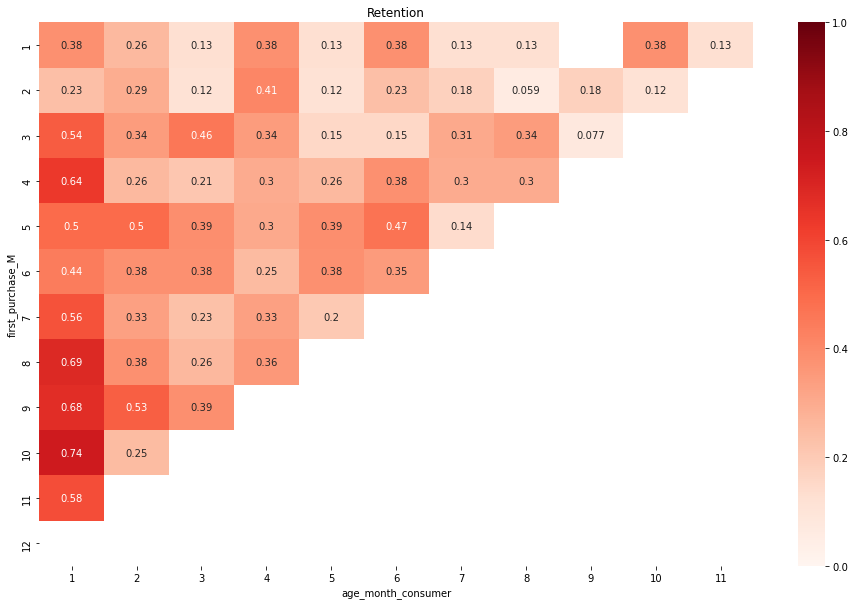

In [69]:
# Рисуем "Тепловую карту"
plt.figure(figsize=(16,10))
plt.title('Retention')
ax = sns.heatmap(data=retention.iloc[:,1:], annot=True, vmin=0.0, vmax=1,cmap='Reds')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()
plt.show()

> **Решение: Когорта с самым высоким retention на 3й месяц - это пользователи, которые совершили первую покупку в марте**

### 6. Построить RFM-сегментацию пользователей для оценки аудитории

В кластеризации выбрать следующие метрики: 
* **R** - время от последней покупки пользователя до текущей даты
* **F** - суммарное количество покупок у пользователя за всё время
* **M** - сумма покупок за всё время

In [70]:
# Работаем с уже готовой таблицей "df_orders_customers_yes" - сделана из двух таблиц и отфильтрована (удалены НЕудавшиеся покупки)
# order_purchase_timestamp - время создания заказа. Будем считать это датой покупки

In [71]:
df_orders_customers_yes.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_YM
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02-01


>#### Этап 1. Создание исходной таблицы с необходимыми атрибутами

In [72]:
# Оставим от этой таблицы только необходимые поля
df_6 = df_orders_customers_yes[['order_id', 'customer_unique_id','order_purchase_timestamp']]
df_6.head()

,order_id,customer_unique_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [73]:
# Добавляем из третьей таблицы "df_items" цену товара. 
# Внимание! В этой таблице нет атрибута "кол-во товара", поэтому скорее всего, при нескольких единицах товара, 
# он повторно указывается в заказе


In [74]:
df_6 = df_6.merge(df_items[['order_id', 'price']])
df_6.head()

,order_id,customer_unique_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,19.90


In [75]:
# Преобразуем поле "order_purchase_timestamp" в тип "date" и переименуем поля
df_6['order_purchase_timestamp'] = df_6['order_purchase_timestamp'].dt.date
df_6 = df_6.rename(columns={"order_purchase_timestamp":"order_date", "customer_unique_id":"cust_id"})
df_6

,order_id,cust_id,order_date,price
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13,19.90
...,...,...,...,...
112081,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06,174.90
112082,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27,205.99
112083,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08,179.99
112084,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08,179.99


In [76]:
# Посмотрим временные рамки покупок
print('Временные рамки покупок: от {} до {}'.format(df_6['order_date'].min(), df_6['order_date'].max()))

Временные рамки покупок: от 2016-09-04 до 2018-09-03


In [77]:
# Текущую дату сделаем на СЛЕДУЮЩИЙ ДЕНЬ после последней даты в нашей базе данных
NOW = df_6['order_date'].max() + timedelta(days=1)
NOW

datetime.date(2018, 9, 4)

>#### Этап 2. Создание базовой таблицы

Для дальнейшего анализа необходимо создать базовую таблицу с полями:
* id-пользователя
* кол-во дней от последнего заказа
* кол-во заказов
* общая сумма потраченных денег 

Создадим ТРИ последних поля через группировку в отдельных таблицах и затем объединим все три таблицы

In [78]:
# Таблица 1. Для каждого пользователя ищем кол-во дней, прошедших от последнего заказа
df_work_01 = df_6.assign(recency = (NOW - df_6.order_date).dt.days)  \
                .groupby("cust_id", as_index=False) \
                .agg({"recency":"min"})
df_work_01.head()

,cust_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120
2,0000f46a3911fa3c0805444483337064,543
3,0000f6ccb0745a6a4b88665a16c9f078,327
4,0004aac84e0df4da2b147fca70cf8255,294


In [79]:
df_work_01.shape

(94970, 2)

In [80]:
# Таблица 2. Для каждого пользователя ищем СУММАРНОЕ кол-во заказов
df_work_02 = df_6 \
                .groupby("cust_id", as_index=False) \
                .agg({"order_id":"count"}) \
                .rename(columns={"order_id":"frequency"})
df_work_02.head()

,cust_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [81]:
df_work_02.shape

(94970, 2)

In [82]:
# Таблица 3. Для каждого пользователя ищем СУММАРНОЕ сумму потраченных денег
df_work_03 = df_6 \
                .groupby("cust_id", as_index=False) \
                .agg({"price":"sum"}) \
                .rename(columns={"price":"monetary"})
df_work_03.head()

,cust_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


In [83]:
df_work_03.shape

(94970, 2)

In [84]:
# Строим из ТРЕХ таблиц - одну. Это - базовая таблица
rfm = df_work_01.merge(df_work_02).merge(df_work_03)
rfm

,cust_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
2,0000f46a3911fa3c0805444483337064,543,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00
...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,453,2,1570.00
94966,fffea47cd6d3cc0a88bd621562a9d061,268,1,64.89
94967,ffff371b4d645b6ecea244b27531430a,574,1,89.90
94968,ffff5962728ec6157033ef9805bacc48,125,1,115.00


>#### Этап 3. Выбор кластеров по каждой метрике

Будем придерживаться следующих принципов выбора кластеров по каждоц метрике:
* по каждой метрике - три кластера
* примерное распределение пользователей в кластерах: 0:20-20:80-80:100 ("сливки"-"середнячки"-"отстающие")
* деление на кластеры в любом случае должно поддаваться здравой интерпретации (например, не может граница метрики "frequency" быть дробной)
* деление метрики "recency" выполняется индивидуально, после анализа гистограммы распределения

In [85]:
# *** МЕТРИКА recency - время от последней покупки пользователя до текущей даты

<AxesSubplot:xlabel='recency', ylabel='Count'>

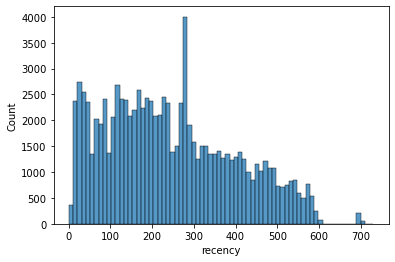

In [86]:
# Посмотрим гистограмму распределения этого параметра
sns.histplot(rfm.recency)

In [87]:
# Посмотрим на распределения пользователей по схеме 0:20-20:80-80:100
rfm['recency'].quantile([.2, .8])

0.2     99.0
0.8    389.0
Name: recency, dtype: float64

In [88]:
# На основании гистограммы принимаем решение, разделить на следующие кластеры: 
# 1: 0-90 дней (3 месяца)
# 2: 91-365 дней (1 год)
# 3: >= 366 дней (более года)

In [89]:
rfm['R'] = pd.cut(rfm.recency, [0,91,366, 10**5], labels=[1,2,3]) 
rfm.head()

,cust_id,recency,frequency,monetary,R
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,2
2,0000f46a3911fa3c0805444483337064,543,1,69.00,3
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2


In [90]:
# Проверим частоты
rfm['R'].value_counts(normalize=True)

2    0.581489
3    0.230515
1    0.187996
Name: R, dtype: float64

In [91]:
# *** МЕТРИКА frequency - суммарное количество покупок у пользователя за всё время

In [92]:
rfm['frequency'].quantile([.2, .8])

0.2    1.0
0.8    1.0
Name: frequency, dtype: float64

In [93]:
# Очевидно, мы не можем принять запланированную схему: большинство покупателей сделали ТОЛЬКО ОДНУ ПОКУПКУ!
# Посмотрим с какими частотами распределен "frequency"
rfm['frequency'].value_counts()

1     83168
2      8948
3      1667
4       629
5       246
6       195
7        46
8        16
11       11
9        11
10       11
12        9
14        3
15        2
13        2
20        2
16        1
18        1
21        1
24        1
Name: frequency, dtype: int64

In [94]:
# На основании этого принимаем решение, разделить на следующие кластеры: 
# 1: 3 покупки и более
# 2: 2 покупки
# 3: 1 покупка

In [95]:
rfm['F'] = pd.cut(rfm.frequency, [0,2,3, 10**5], labels=[3,2,1]) 
rfm.head()

,cust_id,recency,frequency,monetary,R,F
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,2,3
2,0000f46a3911fa3c0805444483337064,543,1,69.00,3,3
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,3
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,3


In [96]:
# Проверим частоты кластеров "F"
rfm['F'].value_counts(normalize=True)

3    0.969948
2    0.017553
1    0.012499
Name: F, dtype: float64

In [97]:
# *** МЕТРИКА monetary - сумма покупок за всё время

In [98]:
rfm['monetary'].quantile([.2, .8])

0.2     39.9
0.8    179.9
Name: monetary, dtype: float64

In [99]:
# На основании этого принимаем решение, разделить на следующие кластеры: 
# 1: >= 180 руб
# 2: >= 40 руб
# 3: < 40 руб

In [100]:
rfm['M'] = pd.cut(rfm.monetary, [0,40,180, 10**10], labels=[3,2,1]) 
rfm.head()

,cust_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2,3,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,2,3,3
2,0000f46a3911fa3c0805444483337064,543,1,69.00,3,3,2
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,3,3
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,3,2


In [101]:
# Проверим частоты кластеров "М"
rfm['M'].value_counts(normalize=True)

2    0.590513
3    0.214584
1    0.194904
Name: M, dtype: float64

> **Решение: RFM-сегментация пользователей - построена**
>
> По каждой из трех метрик построены по 3 кластера. Краткое описание Метрика-Кластеры:
> * recency - время от последней покупки пользователя до текущей даты. Кластеры: [0-90 дней (3 месяца)] [91-365 дней (1 год)] [более 1 года] 
> * frequency - суммарное количество покупок у пользователя за всё время. Кластеры: [3 покупки и более] [2 покупки] [1 покупка]
> * monetary - сумма покупок за всё время. Кластеры: [>= 180 руб] [от 40 до 180 руб] [< 40 руб]
>
> Метрики "recency" и "monetary" делят пользователей по трем кластерам в примерной пропорции 20-60-20.
> У метрики "frequency" в 1-м кластере ("сливки") - около 1% пользователей, во 2-м кластере - 2% пользователей, остальные - в кластере 3 